# Aprendizaje automático

## Tarea 3: Aprendizaje por refuerzos

Martín Beiro

Julián Rodríguez

## Introducción

El problema a resolver se enmarca en una tarea a aprendizaje por refuerzos.
El objetivo es entrenar un agente (en este caso un taxi) para lograr que lleve a cabo una tarea de la mejor manera posible.
El framework a utilizar se importa desde la librería *gymnasium* la cual ya contiene implementaciones propias del aprendizaje por refuerzos disponibles para su utilización.


## Importación y adecuación del ambiente de trabajo

Importamos la biblioteca Gymnassium, que vamos a usar como framework de RL

In [ ]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [ ]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str)

print_env(entorno)


El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero.
'|' representa una pared que el taxi no puede cruzar, es decir.
R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [ ]:
# Una semilla diferente
semilla = 2

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

Exploremos el espacio de estados y de acciones:

In [ ]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacie arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [ ]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

Ahora estamos listos para programar un agente. Empezando por uno random. Se puede ejecutar el codigo abajo varias veces para ver como cambia en cada ejecución, debido a que la semilla_acciones es diferente.

In [ ]:
import random 

def episodio_random(semilla_ambiente = 1):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env
    entorno.reset(seed = semilla_ambiente)

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # para la animación

    termino = False
    truncado = False

    while not termino and not truncado:
        #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
        accion = entorno.action_space.sample() 
        estado, recompensa, termino, truncado, info = entorno.step(accion)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        iteraciones += 1


    print(f"Iteraciones: {iteraciones}")
    print(f"Penalizaciones: {penalizaciones}")

    return marcos

marcos = episodio_random()

Podemos ver el episodio completo abajo. Notar que seleccionamos la semillia de selector de acciones para que la corrida sea 'buena'.

In [ ]:
from IPython.display import clear_output
from time import sleep
import sys

def print_frames(marcos):
    for i, marco in enumerate(marcos):
        clear_output()
        print(marco['marco'])
        print(f"Iteracion: {i + 1}")
        print(f"Estado: {marco['estado']}")
        print(f"Accion: {marco['accion']}")
        print(f"Recompensa: {marco['recompensa']}")
        sys.stdout.flush()
        # Aumentar este tiempo para ver mejor la animación
        sleep(.01)

print_frames(marcos)

Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [ ]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

Para nuestro agente aleatorio, esto sería:

In [ ]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [ ]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env

agente = AgenteAleatorio()

iteraciones = 0
penalizaciones, recompensa = 0, 0

marcos = [] # for animation

termino = False
truncado = False
estado_anterior, info = entorno.reset(seed = semilla)
while not termino and not truncado:
    # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
    accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
    # Realizamos la accion
    estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
    # Le informamos al agente para que aprenda
    agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

    # El agente trato de dejar/recoger al pasajero incorrectamente
    if recompensa == -10:
        penalizaciones += 1

    # Put each rendered frame into dict for animation
    marcos.append({
        'marco': entorno.render(),
        'estado': estado_siguiente,
        'accion': accion,
        'recompensa': recompensa
        }
    )

    estado_anterior = estado_siguiente
    iteraciones += 1


print(f"Iteraciones: {iteraciones}")
print(f"Penalizaciones: {penalizaciones}")

Podemos encapsular lo anterior en una función 

In [ ]:
def ejecutar_episodio(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        estado_anterior = estado_siguiente
        iteraciones += 1
    return iteraciones


y correrlo varias veces para ver el rendimiento promedio

In [ ]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []
for i in range(10):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

Y obtener métricas al respecto

In [ ]:
import numpy
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")

## Programación del algoritmo

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos.\
Con cada itración se actualiza su tabla Q de acuerdo a lo siguiente:

$$\hat Q (s,a)= (1-\alpha)*\hat Q(s,a)+\alpha(r(s,a)+\gamma \max \hat Q(\delta(s,a),a_2) $$

In [ ]:
import numpy as np
import random

class AgenteRL(Agente):
    
    def __init__(self, entorno) -> None:
        super().__init__()
        # Agregar código aqui
        ## hay que inizializar en random

        self.q_table= np.zeros([entorno.observation_space.n, entorno.action_space.n])
        self.gama=0.9
        self.epsilon=0.2
        self.alfa=0.7
        self.k=1
    
    def elegir_accion(self, estado, max_accion) -> int:
        ##aca hay que agregar la aleatoriedad?
        if random.uniform(0,1)<self.epsilon:
            return random.randrange(max_accion)
        else:
            prox_accion=np.argmax(self.q_table[estado])
        return prox_accion
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Agregar código aqui
        self.q_table[estado_anterior][accion]=\
        (1-self.alfa)*self.q_table[estado_anterior][accion]+\
        self.alfa*(recompensa+self.gama*np.max(self.q_table[estado_siguiente]))
        

## Análisis de resultados
### Enternamiento con un única semilla

Se puede ejecutar con el agente muchos episodios con la misma semilla:

In [ ]:
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar
print(entorno.observation_space.n)
agente = AgenteRL(entorno)
semilla = 1
num_ceros_matriz = []
num_iteraciones_episodios = []
for i in range(1000):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    num_ceros_matriz += [np.size(agente.q_table)-np.count_nonzero(agente.q_table)]

Analizar los resultados de la ejecución anterior.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de entrenamiento")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Entrenamiento con semilla=1')

print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")


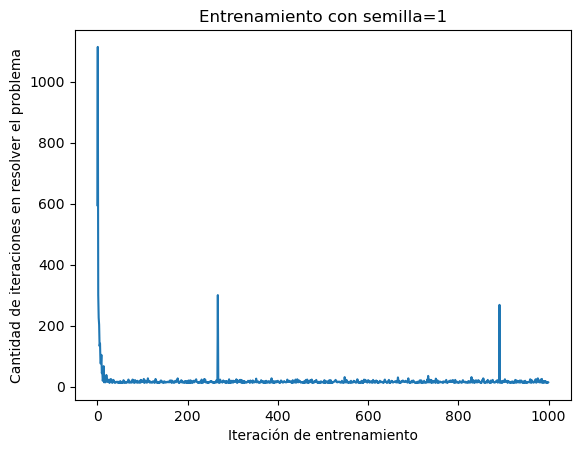

En el gráfico podemos observar como el agente comienza a entrenarse logrando completar la tarea en menor cantidad de iteraciones conforme atraviesa un nuevo entrenamiento.

El promedio de iteraciones (19.3) baja dos órdenes de con especto al agente aleatorio ya que para este caso con cada iteración aprende y mejora sus ejecuciones.

Se mantiene el rendimiento si cambiamos la semilla? Por qué?

Para responder la pregunta se puede implementar un agente que no entrene con cada iteración, y que solo efectúe sus decisiones en base a las del entrenamiento con la semilla inicial.

In [ ]:
def ejecutar_episodio_sin_entrenar(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )
        estado_anterior = estado_siguiente
        iteraciones += 1
        if (iteraciones>100000):
            break
    #print_frames(marcos)

    return iteraciones


semilla = 1
num_iteraciones_episodios = []
# for i in range(1):
num_iteraciones = ejecutar_episodio_sin_entrenar(agente, semilla)
num_iteraciones_episodios += [num_iteraciones]


In [ ]:
semilla = 2
num_iteraciones_episodios = []
for i in range(10):
    num_iteraciones = ejecutar_episodio_sin_entrenar(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    
plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de prueba")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Ejecución con semilla=2')

print(f'La matriz tiene {num_ceros_matriz[-1]} ceros de un total\
de  {np.size(agente.q_table)} entradas')

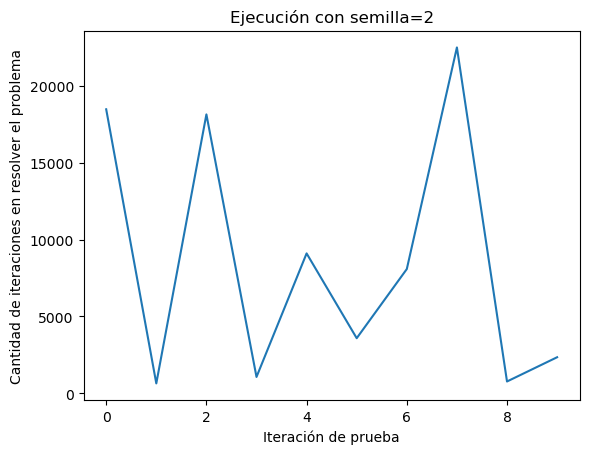

Si probamos el desempeño del agente frente a una nueva semilla, e impidiendo que aprenda, se observa como empeora mucho se rendimiento, lo que indica que no es capaz de resolver el problema de una forma óptima o incluso podría ser capaz de no resolverlo.

Al hallar la cantidad de ceros en la matriz del agente, se observa como gran parte de la matriz (2400 de 3000 entradas) no tiene información. Esto significa que para muchos estados el agente no tiene una política definida.

### Enternamiento con dos semillas

Podemos mejorar el agente para que se desempeñe bien usando cualquier semilla?

Inicialmente podemos entrenar el agente con más de una semilla y evaluar su desempeño.\
Para el siguiente caso se entrenará utilizando las semillas 1 y 2. Adicionalmente se graficará el número de iteraciones que le lleve al agente en completar la tarea.

In [ ]:
agente = AgenteRL(entorno)
semillas = range(1,3)
num_iteraciones_episodios = []
num_ceros_matriz = []
for semilla in semillas:
    for i in range(50):        
        num_iteraciones = ejecutar_episodio(agente, semilla)
        num_iteraciones_episodios += [num_iteraciones]
        num_ceros_matriz += [np.size(agente.q_table)-np.count_nonzero(agente.q_table)]

plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de entrenamiento")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Entrenamiento con semillas=[1,2]')

print(f'La matriz tiene {np.size(agente.q_table)-np.count_nonzero(agente.q_table)} \
ceros de un total de  {np.size(agente.q_table)} entradas')

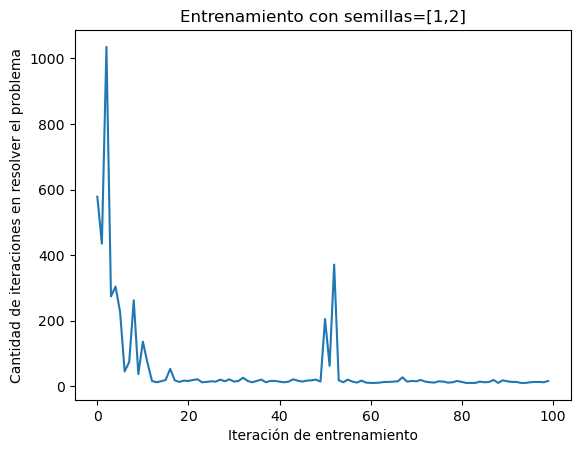

En el gráfico se observa como en las 50 primeras iteraciones se utiliza la semilla 1, logrando que el agente complete la tarea en cada vez menos iteraciones. Las siguientes 50 iteraciones se cambia la semilla, por lo que se observa un desmejoramiento del desempeño, el cual vuelve a mejorar rápidamente. La cantidad de ceros en la matriz permanace incambiada a pesar de que ha expandido su política de decisión.
Resta comprobar si al entrenarse por úlitmo para la semilla 2 es capaz que resolver el problema con la semilla 1 sin volver a entrenar.

In [ ]:
semilla = 1
num_iteraciones_episodios = []
for i in range(1000):
    num_iteraciones = ejecutar_episodio_sin_entrenar(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    
plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de prueba")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Ejecución para semilla=1 entrenado con semillas=[1,2]')

prom_sin_fallas=np.mean(np.array(num_iteraciones_episodios)\
                        [np.array(num_iteraciones_episodios)<100000])
print(f'En los casos de éxito, se realizaron {prom_sin_fallas} \
iteraciones, en promedio.')


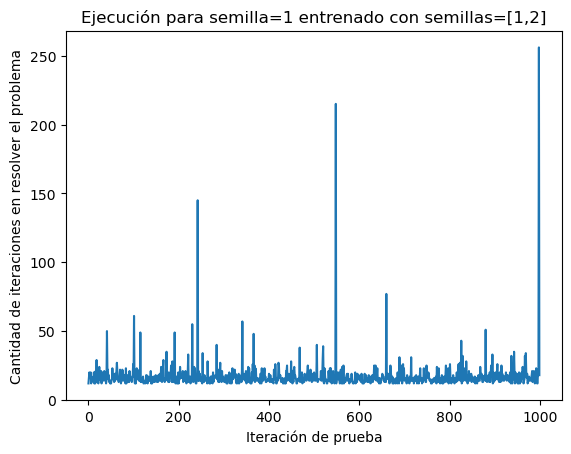

El agente pudo resolver el problema de manera correcta y en una cantidad razonable de iteraciones en la amplia mayoría de los casos (pueden exisitir ejecuciones donde el agente llegue al límite de iteraciones configurado).
En esta instancia será capaz que resolver problemas con semillas que inician el problema de forma similar que la 1 y la 2. A modo de ejemplo, se prueba con la semilla 9, con la cual nunca ha sido entrenada.

In [ ]:
semilla = 9
num_iteraciones_episodios = []
for i in range(1000):
    num_iteraciones = ejecutar_episodio_sin_entrenar(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    
plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de prueba")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Ejecución para semilla=9 entrenado con semillas=[1,2]')

prom_sin_fallas=np.mean(np.array(num_iteraciones_episodios)\
                        [np.array(num_iteraciones_episodios)<100000])
print(f'En los casos de éxito, se realizaron {prom_sin_fallas} \
iteraciones, en promedio.')


Podemos mejorar el agente para que se desempeñe bien usando cualquier semilla?

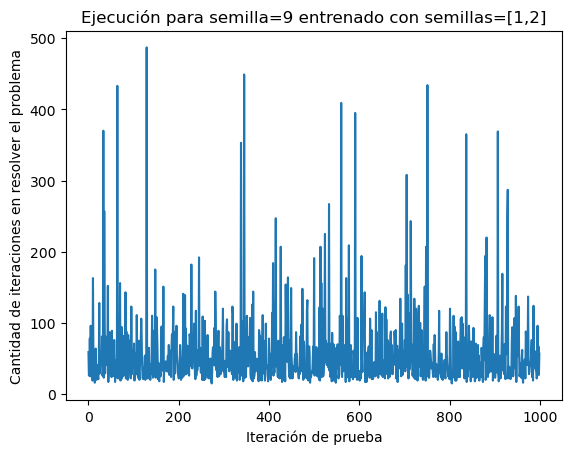

Para el caso anterior, fue capaz que resolver el problema aunque en más iteraciones comparado con la semilla 1.
Por lo tanto, es posible que, si se entrenara con una cantidad suficiente de semillas, el agente pueda dejar al pasajero en destino para una semilla aleatoria.
Para lo siguiente se entrenará con semillas del 1 al 99 corriendo 50 iteraciones por semilla.

## Entrenamiento con varias semillas

Para los siguientes casos se usarán 99 semillas para entrenar el agente y se evaluará su efectividad en culminar la tarea utilizando semillas aleatorias nunca vistas en el entrenamiento.

In [ ]:
agente = AgenteRL(entorno)
semillas = range(1,100)
num_iteraciones_episodios = []
num_ceros_matriz = []
for semilla in semillas:
    for i in range(50):        
        num_iteraciones = ejecutar_episodio(agente, semilla)
        num_iteraciones_episodios += [num_iteraciones]
        num_ceros_matriz += [np.size(agente.q_table)-np.count_nonzero(agente.q_table)]

plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de entrenamiento")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Entrenamiento con semillas=[1,...,99]')

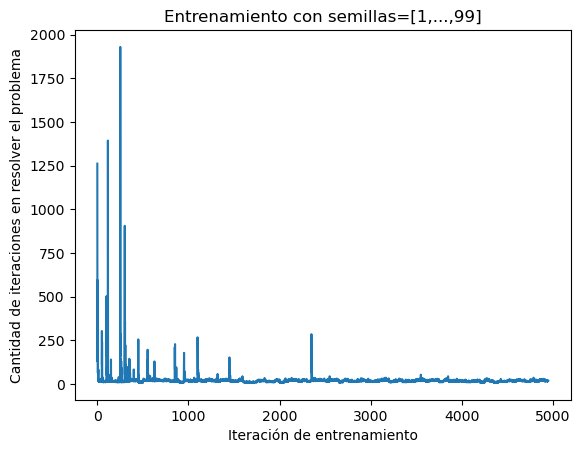

El gráfico muestra como a medida que vamos cambiando las semillas, el agente se entrena cada vez más rápido. Incluso llega a un punto que, con semillas nuevas, su desempeño inicial es bueno. Resta evaluar que sucede con la tabla de decisiones.

In [ ]:
plt.plot(num_ceros_matriz)
plt.xlabel("Iteración de entrenamiento")
plt.ylabel("Cantidad de ceros en la matriz")
plt.title('Cantidad de ceros en la tabla Q durante el entrenamiento')
print(f'La matriz tiene {num_ceros_matriz[-1]} ceros de un total \
de  {np.size(agente.q_table)} entradas')

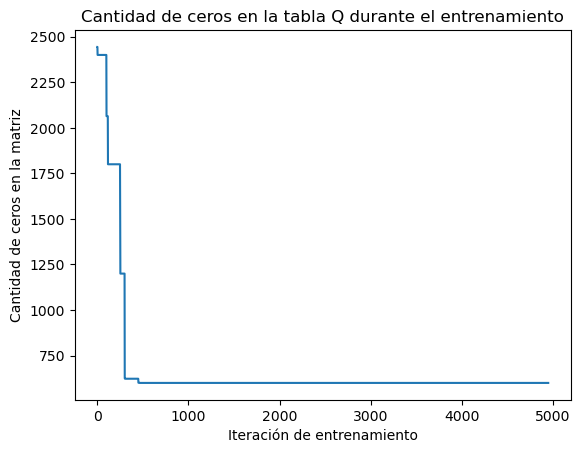\
Si se observa la cantidad de ceros de la tabla Q, ya ha llegado a su límite, ya que solo 400 estados puden ser alcanzados en un episodio para entrenar. Los restantes corresponden a situaciones donde el pasajero llega o aparece justo donde debe bajar, y la tarea ya se da como completada. Por lo que 100 estados por 6 acciones se obtiene la cantidad de ceros límite de entrenamiento.
A continuación se puede probar el desempño utilizando semillas aleatorias.

In [ ]:

num_iteraciones_episodios = []
for i in range(1000):
    semilla = np.random.randint(100,10000)
    num_iteraciones = ejecutar_episodio_sin_entrenar(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    
plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de prueba")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Ejecuciones utilizando semillas aleatorias nunca vistas')

print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")

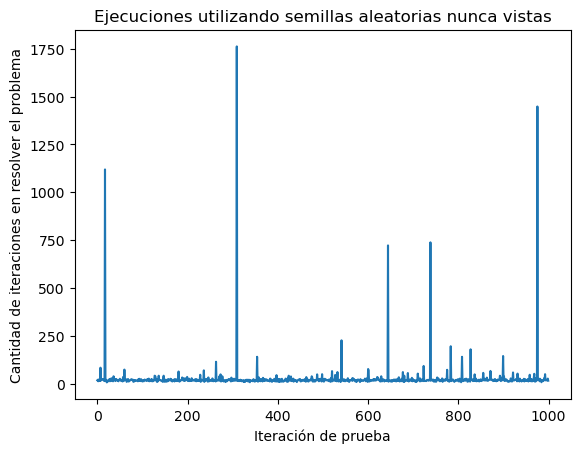

Luego de haberle pasado 1000 semillas aleatrias diferentes a las usadas para el entrenamiento, se observa como el agente es capaz que resolver todos los problemas.
Incluso se podría mejorar el tiempo de entrenamiento poniedo un criterio de parada para cada semilla si logra resolver el problema en menos de uan cantidad arbitraria de iteraciones.

In [ ]:
limite_entrenamiento = 20
agente = AgenteRL(entorno)
semillas = range(1,100)
num_iteraciones_episodios = []
arranque_episodios = []
iteraciones_arranques = []
num_ceros_matriz = []
for semilla in semillas:
    for i in range(50):        
        num_iteraciones = ejecutar_episodio(agente, semilla)
        num_iteraciones_episodios += [num_iteraciones]
        num_ceros_matriz += [np.size(agente.q_table)-np.count_nonzero(agente.q_table)]
        if i ==0:
            arranque_episodios += [len(num_iteraciones_episodios)-1]
            iteraciones_arranques += [num_iteraciones_episodios[-1]]
        if num_iteraciones<limite_entrenamiento:
            break

plt.plot(num_iteraciones_episodios)
plt.plot(arranque_episodios,iteraciones_arranques, '.r', label="Semilla nueva")
plt.xlabel("Iteración de entrenamiento")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Entrenamiento limitado con semillas=[1,...,99]')
plt.legend()
#plt.xlim([98,102])

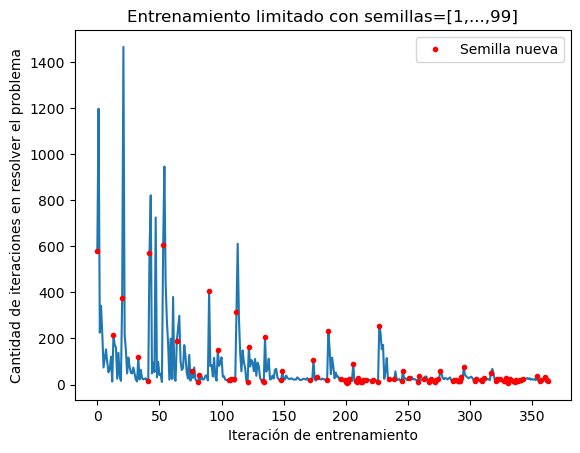

Los puntos rojos representan el inicio de cada entrenamiento con una nueva semilla. La cantidad total de iteraciones usadas con todas las semillas se reduce un orden de magnitud utilizando el criterio mencionado.

In [ ]:
num_iteraciones_episodios = []
for i in range(1000):
    semilla = np.random.randint(100,10000)
    num_iteraciones = ejecutar_episodio_sin_entrenar(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    
plt.plot(num_iteraciones_episodios)
plt.xlabel("Iteración de prueba")
plt.ylabel("Cantidad de iteraciones en resolver el problema")
plt.title('Ejecuciones utilizando semillas aleatorias nunca vistas')

print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")

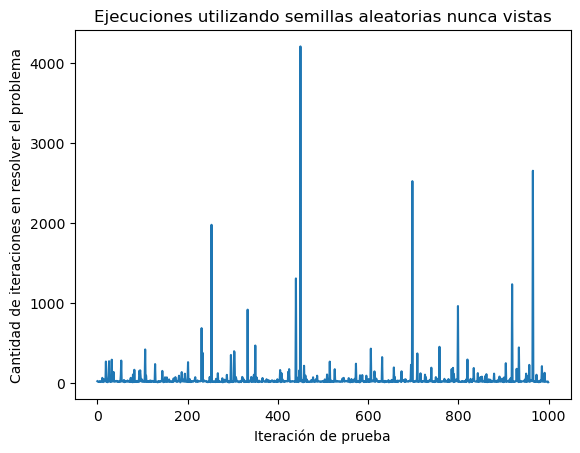

Utilizando nuevamente semillas aleatorias se observa como el agente puede resolver el problema, aunque en una cantidad mayor de iteraciones en promedio. Hay un compromiso entre tiempo de entrenamiento y desempeño al elegir un criterio de parada de entrenamiento para cada semilla.